[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [60]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [61]:
bias = 500
X, y, coef = make_regression(n_samples=5000, 
                             n_features=3, 
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" + 
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" + 
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (113.11, 865.44)
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

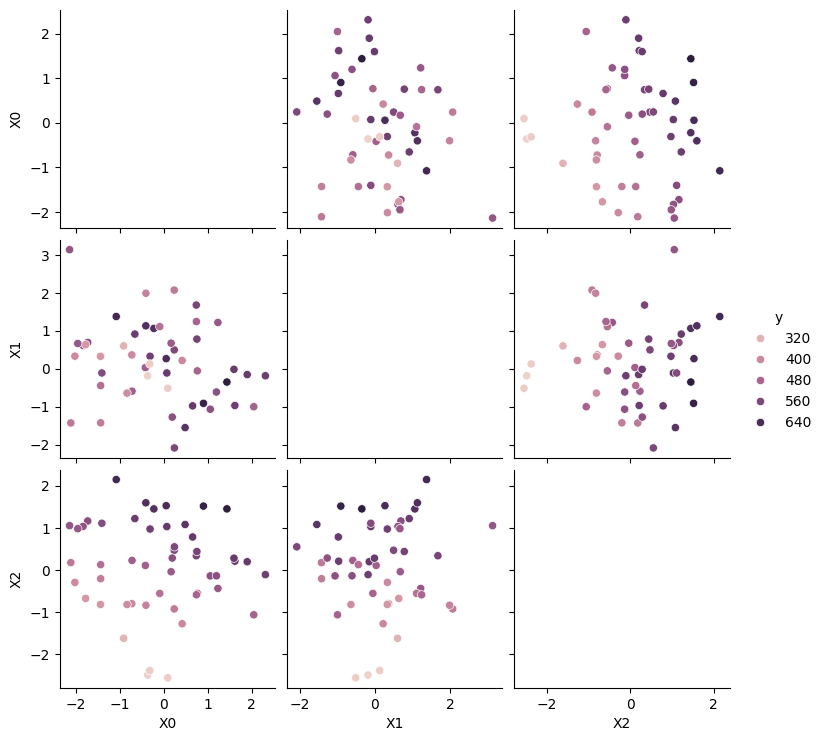

In [62]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [63]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    
    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [64]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [65]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol, verbose=False):
    """
    Descenso de gradiente para minimizar g. 
    Args:
        g: La función a optimizar. 
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia. 
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [66]:
from sklearn import preprocessing
from functools import partial

class RegresionLinealDG():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
   
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)       
                    
        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y, 
                        z_init=np.zeros(w_shape), 
                        **self.descenso_gradiente_hyperparams)


Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [67]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)
 
def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [68]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [69]:
reg.fit(X,y)

Y obtener los w 

In [70]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [71]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [72]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados


(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}` 
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


In [73]:
import numpy as np

In [74]:
def mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, L: float) -> float:
    error = X @ w - y
    return np.mean(error**2) + L * np.sum(w**2)

def grad_mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, L: float) -> np.ndarray:
    error = X @ w - y
    return 2 * (X.T @ error) / len(y) + 2 * L * w

In [75]:
def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, L: float) -> float:
    error = X @ w - y
    return np.mean(error**2) + L * np.sum(np.abs(w))

def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, L: float) -> np.ndarray:
    error = X @ w - y
    return 2 * (X.T @ error) / len(y) + L * np.sign(w)

In [76]:
def mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, L1: float, L2: float) -> float:
    error = X @ w - y
    return np.mean(error**2) + L1 * np.sum(np.abs(w)) + L2 * np.sum(w**2)

def grad_mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, L1: float, L2: float) -> np.ndarray:
    error = X @ w - y
    return 2 * (X.T @ error) / len(y) + L1 * np.sign(w) + 2 * L2 * w

In [77]:
class RegresionLinealDG():
    def __init__(self,
                 func_costo: Callable[..., float],
                 func_costo_grad: Callable[..., np.ndarray],
                 descenso_gradiente_hyperparams_MB: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams_MB = descenso_gradiente_hyperparams_MB
        self.collect_info = False

    def fit(self, X: np.ndarray, y: np.ndarray,minibatch_size) -> None:
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        indices = np.random.choice(np.arange(X.shape[0]), minibatch_size)    # Acá el segundo parámetro me dice el tamaño del mini batch
                                                                
        cost_X_y = partial(self.func_costo, X=X_train_ext[indices], y=y[indices])
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext[indices], y=y[indices])

        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y,
                        z_init=np.zeros(w_shape),
                        **self.descenso_gradiente_hyperparams_MB)

In [78]:
hyperparametros_MB = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}
reg_MB = RegresionLinealDG(mse, grad_mse, hyperparametros_MB)
reg_MB.fit(X,y,1)# Uso 1 y 500 (es el 10% del tamaño del dataset)
print("(DescensoG_MB) w", reg_MB.w.round(1))
err_MB = error_prediccion(X, y, reg_MB.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente_MB_1 {hyperparametros['num_iterations']}"] + list(reg_MB.w) + [err_MB]


(DescensoG_MB) w [ 155.   107.9  -80.1 -158.6]


In [79]:
reg_MB.fit(X,y,500)# Uso 1 y 500 (es el 10% del tamaño del dataset)
print("(DescensoG_MB) w", reg_MB.w.round(1))
err_MB = error_prediccion(X, y, reg_MB.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente_MB_10% {hyperparametros['num_iterations']}"] + list(reg_MB.w) + [err_MB]
resultados

(DescensoG_MB) w [499.6  38.8   1.4  89.9]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradiente_MB_1 1000,155.012084,107.877885,-80.081443,-158.616614,193645.104481
4,DescensoGradiente_MB_10% 1000,499.600070,38.816288,1.376827,89.909138,1.218746
